In [28]:
from __future__ import print_function

In [29]:
import torch

import cv2

import torch.optim as optim
import torch.nn as nn

import sys

import torchvision.transforms as transforms
from torch.autograd import Variable
import random
import torchvision

from torchvision import models
import os
import time
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [30]:
t = torch.Tensor(1,2,3)

In [31]:
t.cuda(0)

tensor([[[ 3.8543e+35,  4.5710e-41,  4.5609e+26],
         [ 0.0000e+00,  4.4842e-44,  0.0000e+00]]], device='cuda:0')

In [32]:
import PIL
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [33]:
#ouvrir l'image
#im = cv2.imread("/home/mrim/portaz/images/chaton.jpeg")
im = PIL.Image.open("/home/mrim/portaz/images/chaton.jpeg")
#im = im[:,:,::-1] # ou im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
inputs = torch.Tensor(1,3,224,224)
trans = transforms.Compose(
                (transforms.Resize(224),
                transforms.CenterCrop(224)
                )
                )
#inputs[0] = trans(im)

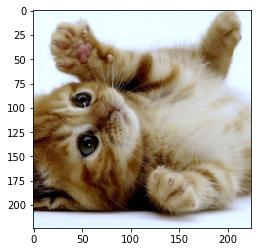

In [34]:
im = PIL.Image.open("/home/mrim/portaz/images/chaton.jpeg")
#im = cv2.imread("/home/mrim/portaz/images/chaton.jpeg")
#im = cv2.resize(im, (224,224))
plt.imshow(trans(im))
plt.savefig("cat.pdf", bbox_inches='tight')

In [35]:
c = nn.Conv2d(3,1,kernel_size=3, bias=False)

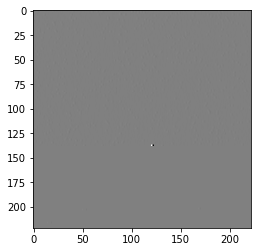

In [36]:
c.state_dict()['weight'].copy_( torch.Tensor([ [ [-1, 0, 1] , [-2,0,2], [-1,0,1] ],
 [ [-1, 0, 1] , [-2,0,2], [-1,0,1]   ],
 [ [-1, 0, 1] , [-2,0,2], [-1,0,1]     ]])
                              )

d = c(Variable(inputs))
plt.imshow(d.data[0].numpy()[0], cmap='gray')
plt.savefig("catConv.pdf", bbox_inches='tight')

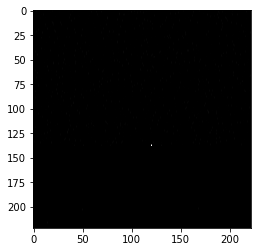

In [37]:
r = nn.ReLU()
rO = r(d)
plt.imshow(rO.data[0][0].numpy(), cmap='gray')
plt.savefig("catRelu.pdf", bbox_inches='tight')

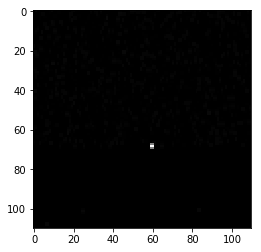

In [38]:
p = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
pO = p(rO)
plt.imshow(pO.data[0][0].numpy(), cmap='gray')
plt.savefig("catPool.pdf", bbox_inches='tight')

In [39]:
def countParams(net):
    p = 0
    for m in net.parameters():
        p += m.data.nelement()
    return p

In [72]:
class IdentityBloc(nn.Module):
    def __init__(self,input_channels, output_channels, nb_groups, nb_frames=1):
        super(IdentityBloc, self).__init__()
        self.conv3 = nn.Conv2d(input_channels*nb_frames, input_channels*nb_frames, kernel_size=3, stride=1, padding=1, groups=nb_groups*nb_frames)
        self.bn3 = nn.BatchNorm2d(input_channels*nb_frames)
        self.conv1 = nn.Conv2d(input_channels*nb_frames, output_channels*nb_frames, kernel_size=1, stride=1, padding=0, groups=nb_frames)
        self.bn1 = nn.BatchNorm2d(output_channels*nb_frames)
        self.relu = nn.ReLU(True)
        
    def forward(self, x):
        right = self.relu(self.conv3(x))
        right = self.relu(self.conv1(right))
        return x.add(right)

In [41]:
class Identity(nn.Module):
    def __init__(self,inp=32, oup=32):
        super(Identity, self).__init__()
        self.conv3 = nn.Conv2d(inp,oup,kernel_size=3,stride=1, padding=1)
        self.b = nn.BatchNorm2d(oup)
        self.r = nn.ReLU(True)
        
    def forward(self,x):
        right = self.r(self.b(self.conv3(x)))
        return x.add(right)

### Timing modules

In [94]:
c = nn.Conv2d(32,32,kernel_size=3)
c1 = nn.Conv2d(32,32,3, groups=32)
c2 = nn.Conv2d(32,32,1)
s = nn.Sequential(
        nn.Conv2d(32,32,3, groups=32),
        nn.Conv2d(32,32,1)
    )

i = Identity(32,32)

print(countParams(c))
print(countParams(c1))
print(countParams(c2))
print(countParams(s))
print(countParams(idB))
print(countParams(i))
t = Variable(torch.rand(64,32,32,32))

9248
320
1056
1376
1504
9312


In [73]:
idB = IdentityBloc(32,32,32)
shuffleBloc1 = ShuffleNet.ShuffleUnit(in_channels=32,out_channels=32,groups=1)
shuffleBloc2 = ShuffleNet.ShuffleUnit(in_channels=32,out_channels=32,groups=2)
shuffleBloc4 = ShuffleNet.ShuffleUnit(in_channels=32,out_channels=32,groups=4)
shuffleBloc = ShuffleNet.ShuffleUnit(in_channels=32,out_channels=32,grouped_conv=False, groups=1)
shuffleBlocg4 = ShuffleNet.ShuffleUnit(in_channels=32,out_channels=32,grouped_conv=False, groups=4)

In [84]:
print(countParams(shuffleBloc))
print(countParams(shuffleBlocg4))
print(countParams(shuffleBloc1))
print(countParams(shuffleBloc2))
print(countParams(shuffleBloc4))

728
536
728
472
344


In [82]:
from torchvision.models import squeezenet as sq
f = sq.Fire(32,8,32,32)
countParams(f)

2888

In [83]:
%%timeit
f(t)

10 loops, best of 3: 22.3 ms per loop


In [49]:
%%timeit
shuffleBloc(t)

100 loops, best of 3: 13.6 ms per loop


In [50]:
%%timeit
shuffleBloc1(t)

100 loops, best of 3: 13.9 ms per loop


In [51]:
%%timeit
shuffleBloc2(t)

10 loops, best of 3: 23 ms per loop


In [52]:
%%timeit
shuffleBloc4(t)

10 loops, best of 3: 21.8 ms per loop


In [130]:
shuffleBloc4C = ShuffleNet.ShuffleUnit(
            32,
            64,
            groups=2,
            grouped_conv=True,
            combine='concat'
            )

In [131]:
print(countParams(shuffleBloc4C))
print(countParams(shuffleBloc4))

848
344


In [134]:
db = SuperMobile.DownBloc(32,32,32,nb_frames=1)
print(countParams(db))

1504


In [132]:
%%timeit
shuffleBloc4C(t)

100 loops, best of 3: 14.9 ms per loop


In [135]:
%%timeit
db(t)

100 loops, best of 3: 13.2 ms per loop


In [15]:
%%timeit
o = c(t)

10 loops, best of 3: 189 ms per loop


In [16]:
%%timeit
o = c1(t)

10 loops, best of 3: 37.2 ms per loop


In [17]:
%%timeit
o = c2(t)

10 loops, best of 3: 30.1 ms per loop


In [18]:
%%timeit
o = s(t)

10 loops, best of 3: 45.1 ms per loop


In [74]:
%%timeit
o = idB(t)

10 loops, best of 3: 24.1 ms per loop


In [20]:
%%timeit
o = i(t)

1 loop, best of 3: 197 ms per loop


# Networks Comparison

In [43]:
!jupyter nbconvert --to python models/ShuffleNet.ipynb
from models import ShuffleNet
reload(ShuffleNet)

[NbConvertApp] Converting notebook models/ShuffleNet.ipynb to python
[NbConvertApp] Writing 9759 bytes to models/ShuffleNet.py


<module 'models.ShuffleNet' from 'models/ShuffleNet.pyc'>

In [22]:
shuffleNet = ShuffleNet.ShuffleNet(in_channels=3,num_classes=6)

In [87]:
sq = models.SqueezeNet()

/usr/local/lib/python2.7/dist-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/usr/local/lib/python2.7/dist-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [88]:
sq

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

In [42]:
!jupyter nbconvert --to python models/SuperMobile.ipynb
from models import SuperMobile
reload(SuperMobile)

[NbConvertApp] Converting notebook models/SuperMobile.ipynb to python
[NbConvertApp] Writing 13373 bytes to models/SuperMobile.py


<module 'models.SuperMobile' from 'models/SuperMobile.pyc'>

In [24]:
supermobile = SuperMobile.DenseMobile(in_channel=3,nb_frames=1, num_classes=6)

In [59]:
!jupyter nbconvert --to python models/MobileNet.ipynb
from models import MobileNet
reload(MobileNet)

[NbConvertApp] Converting notebook models/MobileNet.ipynb to python
[NbConvertApp] Writing 1620 bytes to models/MobileNet.py


<module 'models.MobileNet' from 'models/MobileNet.pyc'>

In [60]:
!jupyter nbconvert --to python models/inception.ipynb
from models import inception
reload(MobileNet)

[NbConvertApp] Converting notebook models/inception.ipynb to python
[NbConvertApp] Writing 8976 bytes to models/inception.py


<module 'models.MobileNet' from 'models/MobileNet.pyc'>

In [26]:
mobilenet = MobileNet.MobileNet(6)

In [27]:
squeeze = models.squeezenet1_1()

In [28]:
alexnet = models.alexnet()

In [66]:
resnet152 = models.resnet152()

In [69]:
resnet101 = models.resnet101()

In [50]:
vgg = models.vgg19_bn()

In [51]:
inception3 = models.inception_v3()

In [61]:
inceptionv4 = inception.inceptionv4()

#### Counting Parameters

In [ ]:
blocS1 = 

In [70]:
print("squeeze", countParams(squeeze))
print("mobile", countParams(mobilenet))
print("shuffle", countParams(shuffleNet))
print("supermobile", countParams(supermobile))
print("alexnet",countParams(alexnet))
print("resnet101",countParams(resnet101))
print("resnet152",countParams(resnet152))
print("vgg", countParams(vgg))
print("inception", countParams(inception3))
print("inception4", countParams(inceptionv4))

squeeze 1235496
mobile 4231976
shuffle 922686
supermobile 772760
alexnet 61100840
resnet101 44549160
resnet152 60192808
vgg 143678248
inception 27161264
inception4 42681353


#### Timing Networks

In [71]:
t = Variable(torch.Tensor(30,3,224,224))

In [72]:
%%timeit
squeeze(t)

1 loop, best of 3: 716 ms per loop


In [73]:
%%timeit
mobilenet(t)

1 loop, best of 3: 1.74 s per loop


In [74]:
%%timeit
shuffleNet(t)

1 loop, best of 3: 749 ms per loop


In [75]:
%%timeit
supermobile(t)

1 loop, best of 3: 843 ms per loop


In [76]:
%%timeit
alexnet(t)

1 loop, best of 3: 1.19 s per loop


In [77]:
%%timeit
resnet101(t)

1 loop, best of 3: 11.9 s per loop


In [78]:
%%timeit
resnet152(t)

1 loop, best of 3: 17.3 s per loop


In [79]:
%%timeit
vgg(t)

1 loop, best of 3: 25.8 s per loop


In [80]:
t = Variable(torch.Tensor(30,3,299,299))

In [81]:
%%timeit
inception3(t)

1 loop, best of 3: 9.29 s per loop


In [82]:
%%timeit
inceptionv4(t)

NameError: global name 'torch' is not defined

### Comparing Fusion

In [33]:
modelF1=SuperMobile.DenseMobileF1()
modelF2=SuperMobile.DenseMobileF2()
modelF3=SuperMobile.DenseMobile()
modelF4=SuperMobile.DenseMobileF4()
modelF5=SuperMobile.DenseMobileF5()

In [34]:
print(countParams(modelF1))
print(countParams(modelF2))
print(countParams(modelF3))
print(countParams(modelF4))
print(countParams(modelF5))

706630
725372
772760
1815740
2119356


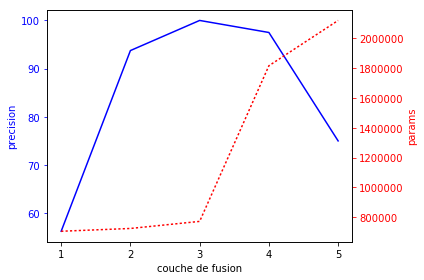

In [49]:
acc = [56.25, 93.75, 100.0, 97.5, 75.0]
params = [countParams(modelF1),
    countParams(modelF2),
    countParams(modelF3),
    countParams(modelF4),
    countParams(modelF5)]
fusion = ['1','2','3','4','5']

from matplotlib.ticker import MaxNLocator

import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
t = fusion
s1 = acc
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('couche de fusion')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('precision', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = params
ax2.plot(t, s2, 'r:')
ax2.set_ylabel('params', color='r')
ax2.tick_params('y', colors='r')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.tight_layout()
plt.savefig('precisionFusion.pdf')
plt.show()